In [1]:
# Import Needed Libraries
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.optimize import minimize
from statsmodels.tsa.ar_model import AutoReg
# from scipy.interpolate import CubicSpline

In [2]:
m2 = pd.read_csv(r"C:\Users\jonat\Downloads\Quant Projects Jonathan\M2.csv")
treasury_yield = pd.read_csv(r"C:\Users\jonat\Downloads\Quant Projects Jonathan\MarketYieldUSTreasuries10Y.csv")
fed_funds_rate = pd.read_csv(r"C:\Users\jonat\Downloads\Quant Projects Jonathan\FederalFundsEffectiveRate.csv")
cpi = pd.read_csv(r"C:\Users\jonat\Downloads\Quant Projects Jonathan\CPI.csv")
gdp_growth = pd.read_csv(r"C:\Users\jonat\Downloads\Quant Projects Jonathan\GDPGrowth.csv")
unemployment_rate = pd.read_csv(r"C:\Users\jonat\Downloads\Quant Projects Jonathan\UnemploymentRate.csv")

In [3]:
print("M2 columns:", m2.columns)
print("Treasury Yield columns:", treasury_yield.columns)
print("Fed Funds Rate columns:", fed_funds_rate.columns)
print("Unemployment Rate columns:", unemployment_rate.columns)
print("CPI columns:", cpi.columns)
print("GDP Growth columns:", gdp_growth.columns)

M2 columns: Index(['DATE', 'WM2NS'], dtype='object')
Treasury Yield columns: Index(['DATE', 'DGS10'], dtype='object')
Fed Funds Rate columns: Index(['DATE', 'DFF'], dtype='object')
Unemployment Rate columns: Index(['DATE', 'UNRATE'], dtype='object')
CPI columns: Index(['DATE', 'CPALTT01USM657N'], dtype='object')
GDP Growth columns: Index(['DATE', 'GDPC1'], dtype='object')


The Need for Resampling Data:

Aligning Data Frequencies
The different datasets have been recorded at different intervals:

Some may be daily: e.g., stock prices, 10Y Treasury Yields while others may be monthly or quarterly: e.g., GDP growth, unemployment rate. 

To effectively merge and analyze these datasets, they need to be on the same time frequency. 

Resampling aligns all data points to a uniform frequency (e.g., monthly), making it easier to perform calculations and analyses without mismatched dates.

Forward fill (ffill) fills in the gaps by carrying forward the last available data point. It makes sense for macroeconomic factors that don't change rapidly on a daily basis (e.g., GDP or unemployment rate). 

Furthermore, resampling ensures that all columns in your dataset have values at the same timestamps, reducing issues when applying time series models or doing regression.

Why monthly? Because many macro indicators like GDP, unemployment rate, and CPI are reported monthly or quarterly.

In [4]:
# data_frames = [m2, treasury_yield, fed_funds_rate, unemployment_rate, cpi, gdp_growth]

# # Ensure all DataFrames have a 'DATE' column in the correct format
# for df in data_frames:
#     # Check if 'DATE' is already a column and correct its format
#     if 'DATE' not in df.columns:
#         raise KeyError("'DATE' column is missing from one of the DataFrames.")
    
#     # Convert 'DATE' column to datetime if not already
#     df['DATE'] = pd.to_datetime(df['DATE'])
    
#     # Set the 'DATE' column as the index
#     df.set_index('DATE', inplace=True)

# # Double-check the type of the index for all DataFrames
# for df in data_frames:
#     if not isinstance(df.index, pd.DatetimeIndex):
#         raise TypeError(f"Index of DataFrame is not a DatetimeIndex but got {type(df.index)}")

# # Resample each DataFrame to a monthly frequency and forward-fill missing values
# m2 = m2.resample('MS').ffill()
# treasury_yield = treasury_yield.resample('MS').ffill()
# fed_funds_rate = fed_funds_rate.resample('MS').ffill()
# unemployment_rate = unemployment_rate.resample('MS').ffill()
# cpi = cpi.resample('MS').ffill()
# gdp_growth = gdp_growth.resample('MS').ffill()

# # Merge all DataFrames on their 'DATE' index
# economic_data = pd.concat([
#     m2['WM2NS'], 
#     treasury_yield['DGS10'], 
#     fed_funds_rate['DFF'], 
#     unemployment_rate['UNRATE'], 
#     cpi['CPALTT01USM657N'], 
#     gdp_growth['GDPC1']
# ], axis=1, join='inner')

# # Rename columns for readability
# economic_data.columns = ['M2', '10Y_Treasury_Yield', 'Fed_Funds_Rate', 'Unemployment_Rate', 'CPI', 'GDP_Growth']

# # Display the merged DataFrame
# print(economic_data.head())

In [5]:
import pandas as pd

# List of your dataframes
data_frames = [m2, treasury_yield, fed_funds_rate, unemployment_rate, cpi, gdp_growth]

# Ensure all DataFrames have a 'DATE' column in the correct format
for df in data_frames:
    # Check if 'DATE' is already a column and correct its format
    if 'DATE' not in df.columns:
        raise KeyError("'DATE' column is missing from one of the DataFrames.")
    
    # Convert 'DATE' column to datetime if not already
    df['DATE'] = pd.to_datetime(df['DATE'])
    
    # Set the 'DATE' column as the index
    df.set_index('DATE', inplace=True)

# Double-check the type of the index for all DataFrames
for df in data_frames:
    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError(f"Index of DataFrame is not a DatetimeIndex but got {type(df.index)}")

# Resample each DataFrame to a weekly frequency and forward-fill missing values
m2 = m2.resample('W-SUN').ffill()
treasury_yield = treasury_yield.resample('W-SUN').ffill()
fed_funds_rate = fed_funds_rate.resample('W-SUN').ffill()
unemployment_rate = unemployment_rate.resample('W-SUN').ffill()
cpi = cpi.resample('W-SUN').ffill()
gdp_growth = gdp_growth.resample('W-SUN').ffill()

# Merge all DataFrames on their 'DATE' index
economic_data = pd.concat([
    m2['WM2NS'], 
    treasury_yield['DGS10'], 
    fed_funds_rate['DFF'], 
    unemployment_rate['UNRATE'], 
    cpi['CPALTT01USM657N'], 
    gdp_growth['GDPC1']
], axis=1, join='inner')

# Rename columns for readability
economic_data.columns = ['M2', '10Y_Treasury_Yield', 'Fed_Funds_Rate', 'Unemployment_Rate', 'CPI', 'GDP_Growth']

# Display the merged DataFrame
print(economic_data.head())

                 M2 10Y_Treasury_Yield  Fed_Funds_Rate  Unemployment_Rate  \
DATE                                                                        
2019-10-06  15012.9               1.52            1.82                3.6   
2019-10-13  15113.9               1.76            1.82                3.6   
2019-10-20  15125.5               1.76            1.85                3.6   
2019-10-27  15116.7               1.80            1.83                3.6   
2019-11-03  15077.4               1.73            1.57                3.6   

                 CPI  GDP_Growth  
DATE                              
2019-10-06  0.228619   20985.448  
2019-10-13  0.228619   20985.448  
2019-10-20  0.228619   20985.448  
2019-10-27  0.228619   20985.448  
2019-11-03 -0.053624   20985.448  


In [6]:
print(f"Number of rows and columns in economic_data: {economic_data.shape}")

Number of rows and columns in economic_data: (231, 6)


In [7]:
# Convert '10Y_Treasury_Yield' to float
economic_data['10Y_Treasury_Yield'] = pd.to_numeric(economic_data['10Y_Treasury_Yield'], errors='coerce')

economic_data.replace('.', np.nan, inplace=True)
economic_data.ffill(inplace=True)
economic_data.dropna(inplace=True)  # Drop any rows that still have missing values after filling
print(economic_data.dtypes)

M2                    float64
10Y_Treasury_Yield    float64
Fed_Funds_Rate        float64
Unemployment_Rate     float64
CPI                   float64
GDP_Growth            float64
dtype: object


In [8]:
print(economic_data.isnull().sum())
print(economic_data.head())

M2                    0
10Y_Treasury_Yield    0
Fed_Funds_Rate        0
Unemployment_Rate     0
CPI                   0
GDP_Growth            0
dtype: int64
                 M2  10Y_Treasury_Yield  Fed_Funds_Rate  Unemployment_Rate  \
DATE                                                                         
2019-10-06  15012.9                1.52            1.82                3.6   
2019-10-13  15113.9                1.76            1.82                3.6   
2019-10-20  15125.5                1.76            1.85                3.6   
2019-10-27  15116.7                1.80            1.83                3.6   
2019-11-03  15077.4                1.73            1.57                3.6   

                 CPI  GDP_Growth  
DATE                              
2019-10-06  0.228619   20985.448  
2019-10-13  0.228619   20985.448  
2019-10-20  0.228619   20985.448  
2019-10-27  0.228619   20985.448  
2019-11-03 -0.053624   20985.448  


In [9]:
# Calculate percentage changes (returns) for selected columns
# Since M2 and 10Y returns are time series data, it makes sense to calculate percentage changes over time.
economic_data['M2_Return'] = economic_data['M2'].pct_change()
economic_data['10Y_Treasury_Yield_Return'] = economic_data['10Y_Treasury_Yield'].pct_change()
economic_data['Fed_Funds_Rate_Change'] = economic_data['Fed_Funds_Rate'].diff()

print(economic_data.head())

                 M2  10Y_Treasury_Yield  Fed_Funds_Rate  Unemployment_Rate  \
DATE                                                                         
2019-10-06  15012.9                1.52            1.82                3.6   
2019-10-13  15113.9                1.76            1.82                3.6   
2019-10-20  15125.5                1.76            1.85                3.6   
2019-10-27  15116.7                1.80            1.83                3.6   
2019-11-03  15077.4                1.73            1.57                3.6   

                 CPI  GDP_Growth  M2_Return  10Y_Treasury_Yield_Return  \
DATE                                                                     
2019-10-06  0.228619   20985.448        NaN                        NaN   
2019-10-13  0.228619   20985.448   0.006728                   0.157895   
2019-10-20  0.228619   20985.448   0.000768                   0.000000   
2019-10-27  0.228619   20985.448  -0.000582                   0.022727   
2019-11-0

In [10]:
# Drop NaNs generated from the return calculations
# economic_data.dropna(inplace=True)
economic_data = economic_data.apply(lambda col: col.fillna(col.median()), axis=0)
print(economic_data.isnull().sum())
economic_data

M2                           0
10Y_Treasury_Yield           0
Fed_Funds_Rate               0
Unemployment_Rate            0
CPI                          0
GDP_Growth                   0
M2_Return                    0
10Y_Treasury_Yield_Return    0
Fed_Funds_Rate_Change        0
dtype: int64


,M2,10Y_Treasury_Yield,Fed_Funds_Rate,Unemployment_Rate,CPI,GDP_Growth,M2_Return,10Y_Treasury_Yield_Return,Fed_Funds_Rate_Change
DATE,,,,,,,,,
2019-10-06,15012.9,1.52,1.82,3.6,0.228619,20985.448,0.001217,0.003187,0.00
2019-10-13,15113.9,1.76,1.82,3.6,0.228619,20985.448,0.006728,0.157895,0.00
2019-10-20,15125.5,1.76,1.85,3.6,0.228619,20985.448,0.000768,0.000000,0.03
2019-10-27,15116.7,1.80,1.83,3.6,0.228619,20985.448,-0.000582,0.022727,-0.02
2019-11-03,15077.4,1.73,1.57,3.6,-0.053624,20985.448,-0.002600,-0.038889,-0.26
...,...,...,...,...,...,...,...,...,...
2024-02-04,20709.7,4.03,5.33,3.9,0.618967,23053.545,-0.002639,-0.028916,0.00
2024-02-11,20837.0,4.17,5.33,3.9,0.618967,23053.545,0.006147,0.034739,0.00
2024-02-18,20706.7,4.30,5.33,3.9,0.618967,23053.545,-0.006253,0.031175,0.00


In [11]:
sp500_data = yf.download('^GSPC', start='2019-01-01', end='2024-01-01')

# Step 2: Clean S&P 500 Data
sp500_data = sp500_data[['Adj Close']]  # Use adjusted close price
sp500_data.rename(columns={'Adj Close': 'S&P500_Close'}, inplace=True)
sp500_data

[*********************100%%**********************]  1 of 1 completed
C:\Users\jonat\AppData\Local\Temp\ipykernel_13676\2786886132.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_data.rename(columns={'Adj Close': 'S&P500_Close'}, inplace=True)


,S&P500_Close
Date,
2019-01-02,2510.030029
2019-01-03,2447.889893
2019-01-04,2531.939941
2019-01-07,2549.689941
2019-01-08,2574.409912
...,...
2023-12-22,4754.629883
2023-12-26,4774.750000
2023-12-27,4781.580078


In [12]:
# Using 20-day rolling window for volatility
sp500_data.loc[:, 'S&P500_Log_Returns'] = np.log(sp500_data['S&P500_Close'] / sp500_data['S&P500_Close'].shift(1))

# Calculate volatility using .loc
sp500_data.loc[:, 'S&P500_Volatility'] = sp500_data['S&P500_Log_Returns'].rolling(window=20).std() * np.sqrt(252)  # Annualized volatility
sp500_data.columns

C:\Users\jonat\AppData\Local\Temp\ipykernel_13676\141488684.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_data.loc[:, 'S&P500_Log_Returns'] = np.log(sp500_data['S&P500_Close'] / sp500_data['S&P500_Close'].shift(1))
C:\Users\jonat\AppData\Local\Temp\ipykernel_13676\141488684.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_data.loc[:, 'S&P500_Volatility'] = sp500_data['S&P500_Log_Returns'].rolling(window=20).std() * np.sqrt(252)  # Annualized volatility


Index(['S&P500_Close', 'S&P500_Log_Returns', 'S&P500_Volatility'], dtype='object')

In [13]:
sp500_data

,S&P500_Close,S&P500_Log_Returns,S&P500_Volatility
Date,,,
2019-01-02,2510.030029,NaN,NaN
2019-01-03,2447.889893,-0.025068,NaN
2019-01-04,2531.939941,0.033759,NaN
2019-01-07,2549.689941,0.006986,NaN
2019-01-08,2574.409912,0.009649,NaN
...,...,...,...
2023-12-22,4754.629883,0.001659,0.096321
2023-12-26,4774.750000,0.004223,0.095365
2023-12-27,4781.580078,0.001429,0.095289


In [14]:
# Fill NaNs in S&P500_Log_Returns with the median
sp500_data['S&P500_Log_Returns'].fillna(sp500_data['S&P500_Log_Returns'].median(), inplace=True)

# Fill NaNs in S&P500_Volatility with the median
sp500_data['S&P500_Volatility'].fillna(sp500_data['S&P500_Volatility'].median(), inplace=True)

print(sp500_data.isnull().sum())
print("")
sp500_data

S&P500_Close          0
S&P500_Log_Returns    0
S&P500_Volatility     0
dtype: int64



C:\Users\jonat\AppData\Local\Temp\ipykernel_13676\2819716790.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_data['S&P500_Log_Returns'].fillna(sp500_data['S&P500_Log_Returns'].median(), inplace=True)
C:\Users\jonat\AppData\Local\Temp\ipykernel_13676\2819716790.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_data['S&P500_Volatility'].fillna(sp500_data['S&P500_Volatility'].median(), inplace=True)


,S&P500_Close,S&P500_Log_Returns,S&P500_Volatility
Date,,,
2019-01-02,2510.030029,0.000903,0.145624
2019-01-03,2447.889893,-0.025068,0.145624
2019-01-04,2531.939941,0.033759,0.145624
2019-01-07,2549.689941,0.006986,0.145624
2019-01-08,2574.409912,0.009649,0.145624
...,...,...,...
2023-12-22,4754.629883,0.001659,0.096321
2023-12-26,4774.750000,0.004223,0.095365
2023-12-27,4781.580078,0.001429,0.095289


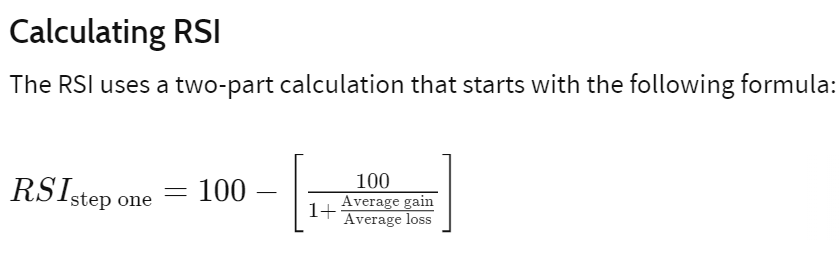

In [15]:
# Calculate RSI using a separate function
def calculate_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Calculate RSI using .loc (recommended way)
sp500_data['S&P500_RSI'] = calculate_rsi(sp500_data['S&P500_Close'])

C:\Users\jonat\AppData\Local\Temp\ipykernel_13676\725130475.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_data['S&P500_RSI'] = calculate_rsi(sp500_data['S&P500_Close'])


In [16]:
sp500_data

,S&P500_Close,S&P500_Log_Returns,S&P500_Volatility,S&P500_RSI
Date,,,,
2019-01-02,2510.030029,0.000903,0.145624,NaN
2019-01-03,2447.889893,-0.025068,0.145624,NaN
2019-01-04,2531.939941,0.033759,0.145624,NaN
2019-01-07,2549.689941,0.006986,0.145624,NaN
2019-01-08,2574.409912,0.009649,0.145624,NaN
...,...,...,...,...
2023-12-22,4754.629883,0.001659,0.096321,75.219000
2023-12-26,4774.750000,0.004223,0.095365,77.026599
2023-12-27,4781.580078,0.001429,0.095289,81.131399


In [17]:
sp500_data['S&P500_RSI'].fillna(sp500_data['S&P500_RSI'].median(), inplace=True)

C:\Users\jonat\AppData\Local\Temp\ipykernel_13676\3410331765.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sp500_data['S&P500_RSI'].fillna(sp500_data['S&P500_RSI'].median(), inplace=True)


In [18]:
sp500_data

,S&P500_Close,S&P500_Log_Returns,S&P500_Volatility,S&P500_RSI
Date,,,,
2019-01-02,2510.030029,0.000903,0.145624,57.960743
2019-01-03,2447.889893,-0.025068,0.145624,57.960743
2019-01-04,2531.939941,0.033759,0.145624,57.960743
2019-01-07,2549.689941,0.006986,0.145624,57.960743
2019-01-08,2574.409912,0.009649,0.145624,57.960743
...,...,...,...,...
2023-12-22,4754.629883,0.001659,0.096321,75.219000
2023-12-26,4774.750000,0.004223,0.095365,77.026599
2023-12-27,4781.580078,0.001429,0.095289,81.131399


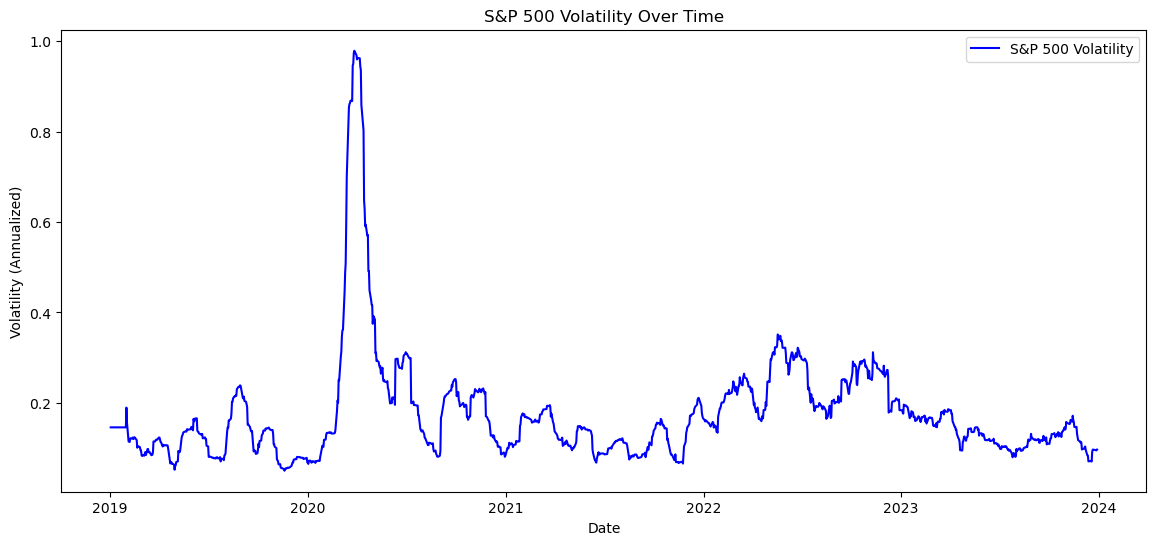

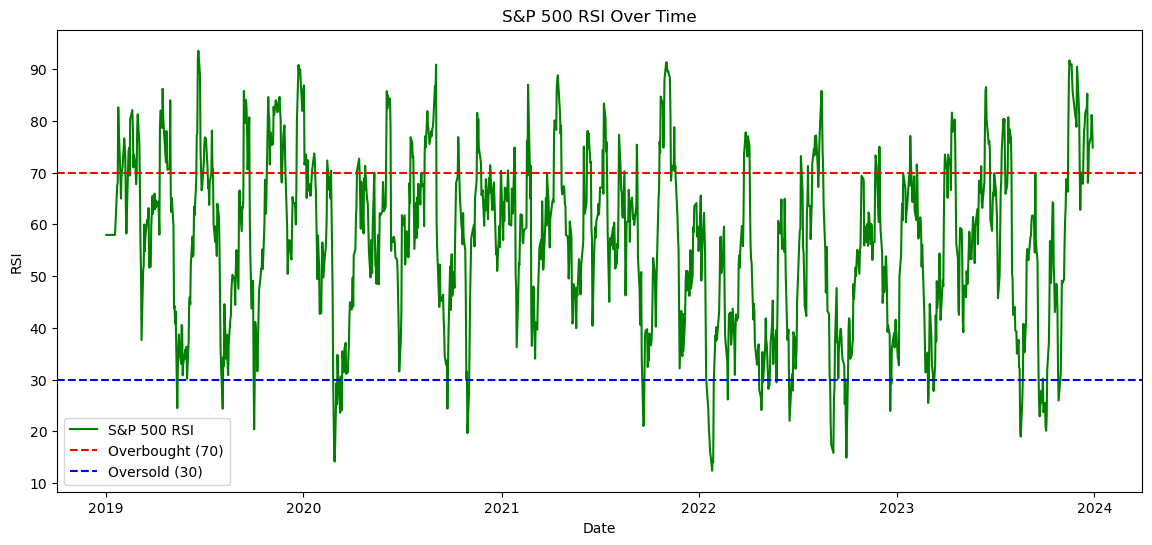

In [19]:
# Plotting S&P 500 Volatility
plt.figure(figsize=(14, 6))
plt.plot(sp500_data.index, sp500_data['S&P500_Volatility'], label='S&P 500 Volatility', color='blue')
plt.title('S&P 500 Volatility Over Time')
plt.xlabel('Date')
plt.ylabel('Volatility (Annualized)')
plt.legend()
plt.show()

# Plotting S&P 500 RSI
plt.figure(figsize=(14, 6))
plt.plot(sp500_data.index, sp500_data['S&P500_RSI'], label='S&P 500 RSI', color='green')
plt.axhline(y=70, color='red', linestyle='--', label='Overbought (70)')
plt.axhline(y=30, color='blue', linestyle='--', label='Oversold (30)')
plt.title('S&P 500 RSI Over Time')
plt.xlabel('Date')
plt.ylabel('RSI')
plt.legend()
plt.show()

In [20]:
print(economic_data.index)
print(sp500_data.index)

DatetimeIndex(['2019-10-06', '2019-10-13', '2019-10-20', '2019-10-27',
               '2019-11-03', '2019-11-10', '2019-11-17', '2019-11-24',
               '2019-12-01', '2019-12-08',
               ...
               '2023-12-31', '2024-01-07', '2024-01-14', '2024-01-21',
               '2024-01-28', '2024-02-04', '2024-02-11', '2024-02-18',
               '2024-02-25', '2024-03-03'],
              dtype='datetime64[ns]', name='DATE', length=231, freq='W-SUN')
DatetimeIndex(['2019-01-02', '2019-01-03', '2019-01-04', '2019-01-07',
               '2019-01-08', '2019-01-09', '2019-01-10', '2019-01-11',
               '2019-01-14', '2019-01-15',
               ...
               '2023-12-15', '2023-12-18', '2023-12-19', '2023-12-20',
               '2023-12-21', '2023-12-22', '2023-12-26', '2023-12-27',
               '2023-12-28', '2023-12-29'],
              dtype='datetime64[ns]', name='Date', length=1258, freq=None)


In [21]:
sp500_data.columns

Index(['S&P500_Close', 'S&P500_Log_Returns', 'S&P500_Volatility',
       'S&P500_RSI'],
      dtype='object')

In [22]:
economic_data.columns

Index(['M2', '10Y_Treasury_Yield', 'Fed_Funds_Rate', 'Unemployment_Rate',
       'CPI', 'GDP_Growth', 'M2_Return', '10Y_Treasury_Yield_Return',
       'Fed_Funds_Rate_Change'],
      dtype='object')

In [23]:
# # Align sp500_data to the start of the month
# sp500_data.index = sp500_data.index.to_period('M').to_timestamp()

In [24]:
duplicates = sp500_data[sp500_data.index.duplicated(keep=False)]
print(duplicates)

Empty DataFrame
Columns: [S&P500_Close, S&P500_Log_Returns, S&P500_Volatility, S&P500_RSI]
Index: []


In [25]:
print(sp500_data.index.is_unique)

True


In [26]:
# duplicated_dates = sp500_data[sp500_data.index.duplicated(keep=False)]
# print(duplicated_dates)

In [27]:
sp500_data.shape

(1258, 4)

In [28]:
# print(sp500_data.index.to_series().diff().value_counts())

In [29]:
# sp500_data = sp500_data[~sp500_data.index.duplicated(keep='first')]
# print(sp500_data.index.to_series().diff().value_counts())
# print("Shape after removing duplicates:", sp500_data.shape)
# sp500_data = sp500_data.resample('W').ffill()  # Weekly forward-fill

In [30]:
# Check for duplicates in the index for all DataFrames
print("Checking for duplicates in economic_data index:", economic_data.index.duplicated().sum())
print("Checking for duplicates in sp500_data index:", sp500_data.index.duplicated().sum())

Checking for duplicates in economic_data index: 0
Checking for duplicates in sp500_data index: 0


In [31]:
# # Remove duplicate index values in sp500_data
# sp500_data = sp500_data[~sp500_data.index.duplicated(keep='first')]

# # Re-check for duplicates to confirm
# print("Checking for duplicates in sp500_data index after removal:", sp500_data.index.duplicated().sum())

In [32]:
# # Correct the typo in the concat function
# merged_data = pd.concat([economic_data, sp500_data], axis=1, join='inner')

# # Display the merged data
# merged_data

In [33]:
merged_data = pd.merge_asof(sp500_data.sort_index(), economic_data.sort_index(), 
                            left_index=True, right_index=True, direction='backward')
merged_data


,S&P500_Close,S&P500_Log_Returns,S&P500_Volatility,S&P500_RSI,M2,10Y_Treasury_Yield,Fed_Funds_Rate,Unemployment_Rate,CPI,GDP_Growth,M2_Return,10Y_Treasury_Yield_Return,Fed_Funds_Rate_Change
Date,,,,,,,,,,,,,
2019-01-02,2510.030029,0.000903,0.145624,57.960743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,2447.889893,-0.025068,0.145624,57.960743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,2531.939941,0.033759,0.145624,57.960743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,2549.689941,0.006986,0.145624,57.960743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,2574.409912,0.009649,0.145624,57.960743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,4754.629883,0.001659,0.096321,75.219000,20800.5,3.91,5.33,3.7,-0.099332,22960.6,-0.000192,-0.075650,0.0
2023-12-26,4774.750000,0.004223,0.095365,77.026599,20872.9,3.90,5.33,3.7,-0.099332,22960.6,0.003481,-0.002558,0.0
2023-12-27,4781.580078,0.001429,0.095289,81.131399,20872.9,3.90,5.33,3.7,-0.099332,22960.6,0.003481,-0.002558,0.0


Missing Values in Each Column:
S&P500_Close                   0
S&P500_Log_Returns             0
S&P500_Volatility              0
S&P500_RSI                     0
M2                           192
10Y_Treasury_Yield           192
Fed_Funds_Rate               192
Unemployment_Rate            192
CPI                          192
GDP_Growth                   192
M2_Return                    192
10Y_Treasury_Yield_Return    192
Fed_Funds_Rate_Change        192
dtype: int64

Number of Duplicate Dates: 0

Missing Dates: DatetimeIndex(['2019-06-01', '2019-09-01', '2019-12-01', '2020-01-01',
               '2020-02-01', '2020-03-01', '2020-08-01', '2020-11-01',
               '2021-01-01', '2021-05-01', '2021-08-01', '2022-01-01',
               '2022-05-01', '2022-10-01', '2023-01-01', '2023-04-01',
               '2023-07-01', '2023-10-01'],
              dtype='datetime64[ns]', freq=None)



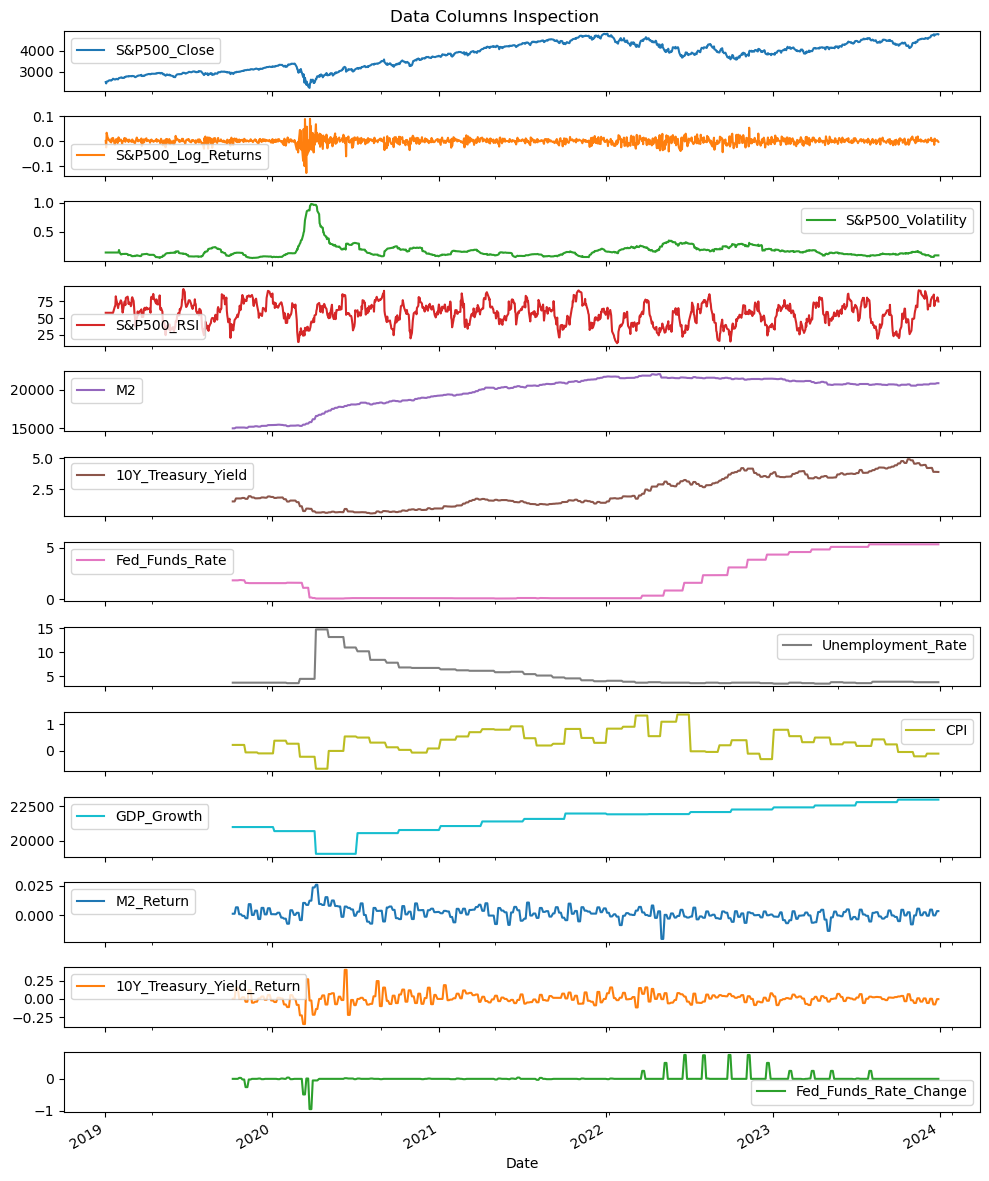

In [34]:
# Check for missing values in each column
missing_values = merged_data.isnull().sum()
print("Missing Values in Each Column:")
print(missing_values)

print("")

# Check for duplicates in the index
duplicate_dates = merged_data.index.duplicated().sum()
print(f"Number of Duplicate Dates: {duplicate_dates}")

print("")

# Check for any gaps in the monthly date range
all_dates = pd.date_range(start=merged_data.index.min(), end=merged_data.index.max(), freq='MS')
missing_dates = all_dates.difference(merged_data.index)
print(f"Missing Dates: {missing_dates}")

print("")

# Plot each column to visually inspect for anomalies
merged_data.plot(subplots=True, figsize=(10, 12), title='Data Columns Inspection')
plt.tight_layout()
plt.show()

For the graph, it can be seen that the Unemployment Rate in early 2020 has a massive spike, which makes sense as it aligns with the pandemic, but confirm that it’s correct.

The S&P500 Volatility and RSI seem to move within expected ranges.

M2 shows a consistent upward trend, which is typical, but double-check that it aligns with actual historical data.

In [35]:
# Fill missing values in columns with their respective median values
for column in merged_data.columns:
    if merged_data[column].isnull().sum() > 0:
        median_value = merged_data[column].median()
        merged_data[column].fillna(median_value, inplace=True)

# Display to verify changes
print("Missing Values in Each Column After Filling:")
print(merged_data.isnull().sum())

print("")
merged_data

Missing Values in Each Column After Filling:
S&P500_Close                 0
S&P500_Log_Returns           0
S&P500_Volatility            0
S&P500_RSI                   0
M2                           0
10Y_Treasury_Yield           0
Fed_Funds_Rate               0
Unemployment_Rate            0
CPI                          0
GDP_Growth                   0
M2_Return                    0
10Y_Treasury_Yield_Return    0
Fed_Funds_Rate_Change        0
dtype: int64



,S&P500_Close,S&P500_Log_Returns,S&P500_Volatility,S&P500_RSI,M2,10Y_Treasury_Yield,Fed_Funds_Rate,Unemployment_Rate,CPI,GDP_Growth,M2_Return,10Y_Treasury_Yield_Return,Fed_Funds_Rate_Change
Date,,,,,,,,,,,,,
2019-01-02,2510.030029,0.000903,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,0.001389,0.004298,0.0
2019-01-03,2447.889893,-0.025068,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,0.001389,0.004298,0.0
2019-01-04,2531.939941,0.033759,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,0.001389,0.004298,0.0
2019-01-07,2549.689941,0.006986,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,0.001389,0.004298,0.0
2019-01-08,2574.409912,0.009649,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,0.001389,0.004298,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,4754.629883,0.001659,0.096321,75.219000,20800.5,3.910,5.33,3.7,-0.099332,22960.60,-0.000192,-0.075650,0.0
2023-12-26,4774.750000,0.004223,0.095365,77.026599,20872.9,3.900,5.33,3.7,-0.099332,22960.60,0.003481,-0.002558,0.0
2023-12-27,4781.580078,0.001429,0.095289,81.131399,20872.9,3.900,5.33,3.7,-0.099332,22960.60,0.003481,-0.002558,0.0


In [36]:
for col in merged_data.columns:
    merged_data[f'{col}_diff'] = merged_data[col].diff()
    merged_data[f'{col}_pct_change'] = merged_data[col].pct_change()

# Moving averages and other features based on S&P500
sp500_close = merged_data['S&P500_Volatility']

# Calculate 3-month and 6-month moving averages for S&P 500
merged_data['S&P500_3M_MA'] = sp500_close.rolling(window=3).mean()
merged_data['S&P500_6M_MA'] = sp500_close.rolling(window=6).mean()

In [37]:
target_series = merged_data['S&P500_Log_Returns']

max_lag = 20  # Adjust based on your data

# Get the AIC and BIC for each lag
aic_values = []
bic_values = []

for lag in range(1, max_lag + 1):
    model = AutoReg(target_series, lags=lag, old_names=False).fit()
    aic_values.append(model.aic)
    bic_values.append(model.bic)

# Find the optimal lag based on the minimum AIC and BIC
optimal_lag_aic = aic_values.index(min(aic_values)) + 1
optimal_lag_bic = bic_values.index(min(bic_values)) + 1

print(f"Optimal lag length based on AIC: {optimal_lag_aic}")
print(f"Optimal lag length based on BIC: {optimal_lag_bic}")

Optimal lag length based on AIC: 9
Optimal lag length based on BIC: 9


c:\Users\jonat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jonat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jonat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\jonat\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(d

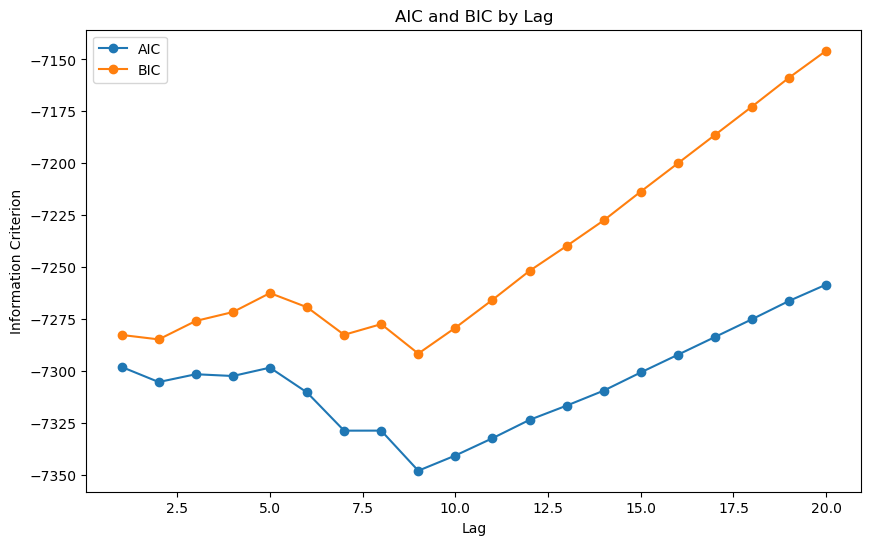

In [38]:
# Plot AIC and BIC values
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_lag + 1), aic_values, marker='o', label='AIC')
plt.plot(range(1, max_lag + 1), bic_values, marker='o', label='BIC')
plt.xlabel('Lag')
plt.ylabel('Information Criterion')
plt.title('AIC and BIC by Lag')
plt.legend()
plt.show()

In [39]:
optimal_lag = 9

# Create lagged features for S&P500_Log_Returns
for lag in range(1, optimal_lag + 1):
    merged_data[f'S&P500_Log_Returns_Lag_{lag}'] = merged_data['S&P500_Log_Returns'].shift(lag)

# Check the head of merged_data to ensure lagged features are added
merged_data

,S&P500_Close,S&P500_Log_Returns,S&P500_Volatility,S&P500_RSI,M2,10Y_Treasury_Yield,Fed_Funds_Rate,Unemployment_Rate,CPI,GDP_Growth,...,S&P500_6M_MA,S&P500_Log_Returns_Lag_1,S&P500_Log_Returns_Lag_2,S&P500_Log_Returns_Lag_3,S&P500_Log_Returns_Lag_4,S&P500_Log_Returns_Lag_5,S&P500_Log_Returns_Lag_6,S&P500_Log_Returns_Lag_7,S&P500_Log_Returns_Lag_8,S&P500_Log_Returns_Lag_9
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2510.030029,0.000903,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-03,2447.889893,-0.025068,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,...,NaN,0.000903,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04,2531.939941,0.033759,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,...,NaN,-0.025068,0.000903,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07,2549.689941,0.006986,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,...,NaN,0.033759,-0.025068,0.000903,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-08,2574.409912,0.009649,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,...,NaN,0.006986,0.033759,-0.025068,0.000903,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,4754.629883,0.001659,0.096321,75.219000,20800.5,3.910,5.33,3.7,-0.099332,22960.60,...,0.082770,0.010249,-0.014793,0.005849,0.004518,-0.000076,0.002644,0.013558,0.004589,0.003917
2023-12-26,4774.750000,0.004223,0.095365,77.026599,20872.9,3.900,5.33,3.7,-0.099332,22960.60,...,0.086858,0.001659,0.010249,-0.014793,0.005849,0.004518,-0.000076,0.002644,0.013558,0.004589
2023-12-27,4781.580078,0.001429,0.095289,81.131399,20872.9,3.900,5.33,3.7,-0.099332,22960.60,...,0.090879,0.004223,0.001659,0.010249,-0.014793,0.005849,0.004518,-0.000076,0.002644,0.013558


In [40]:
for column in merged_data.columns:
    if merged_data[column].isnull().sum() > 0:
        median_value = merged_data[column].median()
        merged_data[column].fillna(median_value, inplace=True)

# Display to verify changes
print("Missing Values in Each Column After Filling:")
print(merged_data.isnull().sum())

print("")
merged_data

Missing Values in Each Column After Filling:
S&P500_Close                            0
S&P500_Log_Returns                      0
S&P500_Volatility                       0
S&P500_RSI                              0
M2                                      0
10Y_Treasury_Yield                      0
Fed_Funds_Rate                          0
Unemployment_Rate                       0
CPI                                     0
GDP_Growth                              0
M2_Return                               0
10Y_Treasury_Yield_Return               0
Fed_Funds_Rate_Change                   0
S&P500_Close_diff                       0
S&P500_Close_pct_change                 0
S&P500_Log_Returns_diff                 0
S&P500_Log_Returns_pct_change           0
S&P500_Volatility_diff                  0
S&P500_Volatility_pct_change            0
S&P500_RSI_diff                         0
S&P500_RSI_pct_change                   0
M2_diff                                 0
M2_pct_change                  

,S&P500_Close,S&P500_Log_Returns,S&P500_Volatility,S&P500_RSI,M2,10Y_Treasury_Yield,Fed_Funds_Rate,Unemployment_Rate,CPI,GDP_Growth,...,S&P500_6M_MA,S&P500_Log_Returns_Lag_1,S&P500_Log_Returns_Lag_2,S&P500_Log_Returns_Lag_3,S&P500_Log_Returns_Lag_4,S&P500_Log_Returns_Lag_5,S&P500_Log_Returns_Lag_6,S&P500_Log_Returns_Lag_7,S&P500_Log_Returns_Lag_8,S&P500_Log_Returns_Lag_9
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2510.030029,0.000903,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,...,0.145624,0.000903,0.000906,0.000903,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
2019-01-03,2447.889893,-0.025068,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,...,0.145624,0.000903,0.000906,0.000903,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
2019-01-04,2531.939941,0.033759,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,...,0.145624,-0.025068,0.000903,0.000903,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
2019-01-07,2549.689941,0.006986,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,...,0.145624,0.033759,-0.025068,0.000903,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
2019-01-08,2574.409912,0.009649,0.145624,57.960743,20686.9,1.775,0.33,3.8,0.315321,21903.85,...,0.145624,0.006986,0.033759,-0.025068,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,4754.629883,0.001659,0.096321,75.219000,20800.5,3.910,5.33,3.7,-0.099332,22960.60,...,0.082770,0.010249,-0.014793,0.005849,0.004518,-0.000076,0.002644,0.013558,0.004589,0.003917
2023-12-26,4774.750000,0.004223,0.095365,77.026599,20872.9,3.900,5.33,3.7,-0.099332,22960.60,...,0.086858,0.001659,0.010249,-0.014793,0.005849,0.004518,-0.000076,0.002644,0.013558,0.004589
2023-12-27,4781.580078,0.001429,0.095289,81.131399,20872.9,3.900,5.33,3.7,-0.099332,22960.60,...,0.090879,0.004223,0.001659,0.010249,-0.014793,0.005849,0.004518,-0.000076,0.002644,0.013558


In [41]:
merged_data.columns

Index(['S&P500_Close', 'S&P500_Log_Returns', 'S&P500_Volatility', 'S&P500_RSI',
       'M2', '10Y_Treasury_Yield', 'Fed_Funds_Rate', 'Unemployment_Rate',
       'CPI', 'GDP_Growth', 'M2_Return', '10Y_Treasury_Yield_Return',
       'Fed_Funds_Rate_Change', 'S&P500_Close_diff', 'S&P500_Close_pct_change',
       'S&P500_Log_Returns_diff', 'S&P500_Log_Returns_pct_change',
       'S&P500_Volatility_diff', 'S&P500_Volatility_pct_change',
       'S&P500_RSI_diff', 'S&P500_RSI_pct_change', 'M2_diff', 'M2_pct_change',
       '10Y_Treasury_Yield_diff', '10Y_Treasury_Yield_pct_change',
       'Fed_Funds_Rate_diff', 'Fed_Funds_Rate_pct_change',
       'Unemployment_Rate_diff', 'Unemployment_Rate_pct_change', 'CPI_diff',
       'CPI_pct_change', 'GDP_Growth_diff', 'GDP_Growth_pct_change',
       'M2_Return_diff', 'M2_Return_pct_change',
       '10Y_Treasury_Yield_Return_diff',
       '10Y_Treasury_Yield_Return_pct_change', 'Fed_Funds_Rate_Change_diff',
       'Fed_Funds_Rate_Change_pct_change', 'S&

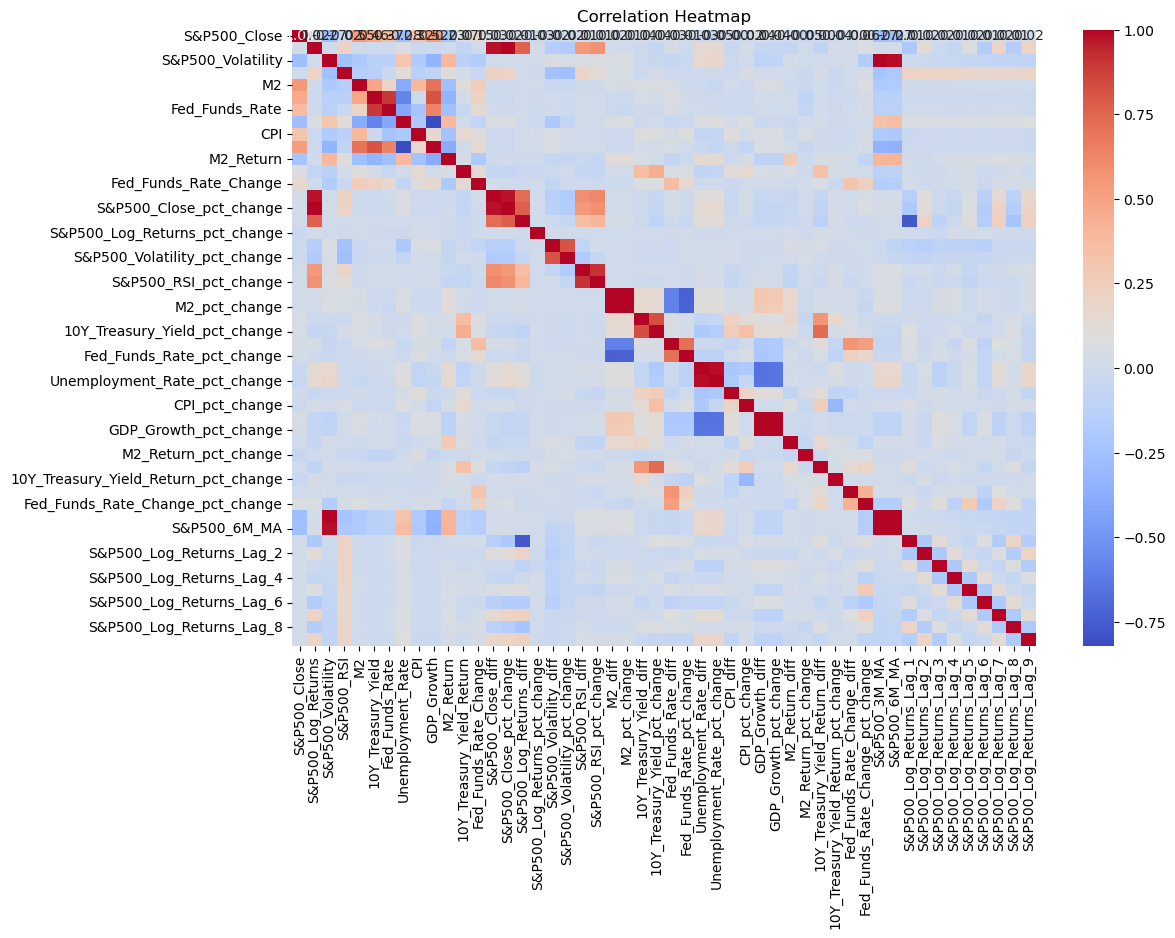

In [42]:
plt.figure(figsize=(12, 8))
sns.heatmap(merged_data.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()
# To check if there is multicollinearity between factors

In [43]:
# Decided to drop original raw data
# List of original columns to drop
columns_to_drop = ['M2', '10Y_Treasury_Yield', 'Fed_Funds_Rate', 
                   'Unemployment_Rate', 'CPI', 'GDP_Growth']

# Drop the columns from the DataFrame
merged_data_cleaned = merged_data.drop(columns=columns_to_drop)

merged_data_cleaned

,S&P500_Close,S&P500_Log_Returns,S&P500_Volatility,S&P500_RSI,M2_Return,10Y_Treasury_Yield_Return,Fed_Funds_Rate_Change,S&P500_Close_diff,S&P500_Close_pct_change,S&P500_Log_Returns_diff,...,S&P500_6M_MA,S&P500_Log_Returns_Lag_1,S&P500_Log_Returns_Lag_2,S&P500_Log_Returns_Lag_3,S&P500_Log_Returns_Lag_4,S&P500_Log_Returns_Lag_5,S&P500_Log_Returns_Lag_6,S&P500_Log_Returns_Lag_7,S&P500_Log_Returns_Lag_8,S&P500_Log_Returns_Lag_9
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2510.030029,0.000903,0.145624,57.960743,0.001389,0.004298,0.0,3.440186,0.000903,-0.000327,...,0.145624,0.000903,0.000906,0.000903,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
2019-01-03,2447.889893,-0.025068,0.145624,57.960743,0.001389,0.004298,0.0,-62.140137,-0.024757,-0.025971,...,0.145624,0.000903,0.000906,0.000903,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
2019-01-04,2531.939941,0.033759,0.145624,57.960743,0.001389,0.004298,0.0,84.050049,0.034336,0.058828,...,0.145624,-0.025068,0.000903,0.000903,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
2019-01-07,2549.689941,0.006986,0.145624,57.960743,0.001389,0.004298,0.0,17.750000,0.007010,-0.026773,...,0.145624,0.033759,-0.025068,0.000903,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
2019-01-08,2574.409912,0.009649,0.145624,57.960743,0.001389,0.004298,0.0,24.719971,0.009695,0.002663,...,0.145624,0.006986,0.033759,-0.025068,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,4754.629883,0.001659,0.096321,75.219000,-0.000192,-0.075650,0.0,7.879883,0.001660,-0.008590,...,0.082770,0.010249,-0.014793,0.005849,0.004518,-0.000076,0.002644,0.013558,0.004589,0.003917
2023-12-26,4774.750000,0.004223,0.095365,77.026599,0.003481,-0.002558,0.0,20.120117,0.004232,0.002564,...,0.086858,0.001659,0.010249,-0.014793,0.005849,0.004518,-0.000076,0.002644,0.013558,0.004589
2023-12-27,4781.580078,0.001429,0.095289,81.131399,0.003481,-0.002558,0.0,6.830078,0.001430,-0.002793,...,0.090879,0.004223,0.001659,0.010249,-0.014793,0.005849,0.004518,-0.000076,0.002644,0.013558


In [44]:
# Check for any remaining NaN values
print(merged_data_cleaned.isnull().sum())
merged_data_cleaned

S&P500_Close                            0
S&P500_Log_Returns                      0
S&P500_Volatility                       0
S&P500_RSI                              0
M2_Return                               0
10Y_Treasury_Yield_Return               0
Fed_Funds_Rate_Change                   0
S&P500_Close_diff                       0
S&P500_Close_pct_change                 0
S&P500_Log_Returns_diff                 0
S&P500_Log_Returns_pct_change           0
S&P500_Volatility_diff                  0
S&P500_Volatility_pct_change            0
S&P500_RSI_diff                         0
S&P500_RSI_pct_change                   0
M2_diff                                 0
M2_pct_change                           0
10Y_Treasury_Yield_diff                 0
10Y_Treasury_Yield_pct_change           0
Fed_Funds_Rate_diff                     0
Fed_Funds_Rate_pct_change               0
Unemployment_Rate_diff                  0
Unemployment_Rate_pct_change            0
CPI_diff                          

,S&P500_Close,S&P500_Log_Returns,S&P500_Volatility,S&P500_RSI,M2_Return,10Y_Treasury_Yield_Return,Fed_Funds_Rate_Change,S&P500_Close_diff,S&P500_Close_pct_change,S&P500_Log_Returns_diff,...,S&P500_6M_MA,S&P500_Log_Returns_Lag_1,S&P500_Log_Returns_Lag_2,S&P500_Log_Returns_Lag_3,S&P500_Log_Returns_Lag_4,S&P500_Log_Returns_Lag_5,S&P500_Log_Returns_Lag_6,S&P500_Log_Returns_Lag_7,S&P500_Log_Returns_Lag_8,S&P500_Log_Returns_Lag_9
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,2510.030029,0.000903,0.145624,57.960743,0.001389,0.004298,0.0,3.440186,0.000903,-0.000327,...,0.145624,0.000903,0.000906,0.000903,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
2019-01-03,2447.889893,-0.025068,0.145624,57.960743,0.001389,0.004298,0.0,-62.140137,-0.024757,-0.025971,...,0.145624,0.000903,0.000906,0.000903,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
2019-01-04,2531.939941,0.033759,0.145624,57.960743,0.001389,0.004298,0.0,84.050049,0.034336,0.058828,...,0.145624,-0.025068,0.000903,0.000903,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
2019-01-07,2549.689941,0.006986,0.145624,57.960743,0.001389,0.004298,0.0,17.750000,0.007010,-0.026773,...,0.145624,0.033759,-0.025068,0.000903,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
2019-01-08,2574.409912,0.009649,0.145624,57.960743,0.001389,0.004298,0.0,24.719971,0.009695,0.002663,...,0.145624,0.006986,0.033759,-0.025068,0.000903,0.000903,0.000900,0.000903,0.000900,0.000898
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-22,4754.629883,0.001659,0.096321,75.219000,-0.000192,-0.075650,0.0,7.879883,0.001660,-0.008590,...,0.082770,0.010249,-0.014793,0.005849,0.004518,-0.000076,0.002644,0.013558,0.004589,0.003917
2023-12-26,4774.750000,0.004223,0.095365,77.026599,0.003481,-0.002558,0.0,20.120117,0.004232,0.002564,...,0.086858,0.001659,0.010249,-0.014793,0.005849,0.004518,-0.000076,0.002644,0.013558,0.004589
2023-12-27,4781.580078,0.001429,0.095289,81.131399,0.003481,-0.002558,0.0,6.830078,0.001430,-0.002793,...,0.090879,0.004223,0.001659,0.010249,-0.014793,0.005849,0.004518,-0.000076,0.002644,0.013558


In [45]:
print(f"Number of rows and columns in economic_data: {merged_data_cleaned.shape}")

Number of rows and columns in economic_data: (1258, 44)


In [46]:
# # Create copies of the original column to handle infinite values separately
# filled_mean = merged_data_cleaned['Fed_Funds_Rate_Change_pct_change'].copy()
# filled_median = merged_data_cleaned['Fed_Funds_Rate_Change_pct_change'].copy()

# # Replace infinite values with NaN
# filled_mean.replace([np.inf, -np.inf], np.nan, inplace=True)
# filled_median.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Fill NaN values with mean and median respectively
# filled_mean.fillna(filled_mean.mean(), inplace=True)
# filled_median.fillna(filled_median.median(), inplace=True)

In [47]:
# # Check if there are any infinite values
# print("Number of Inf values (filled_mean):", np.isinf(filled_mean).sum())
# print("Number of Inf values (filled_median):", np.isinf(filled_median).sum())

# # Replace Inf values with NaN for both filled_mean and filled_median
# filled_mean.replace([np.inf, -np.inf], np.nan, inplace=True)
# filled_median.replace([np.inf, -np.inf], np.nan, inplace=True)

# # Now fill NaNs (if any remaining) again with mean or median
# filled_mean.fillna(filled_mean.mean(), inplace=True)
# filled_median.fillna(filled_median.median(), inplace=True)

In [48]:
# # Plot histograms with adjusted x-range
# plt.figure(figsize=(10, 6))
# plt.hist(filled_mean, bins=50, alpha=0.5, label='Filled with Mean', color='blue', range=(-5, 5))
# plt.hist(filled_median, bins=50, alpha=0.5, label='Filled with Median', color='orange', range=(-5, 5))
# plt.xlabel('Fed Funds Rate Change')
# plt.ylabel('Frequency')
# plt.title('Comparison of Filling NaNs with Mean vs Median (Zoomed in)')
# plt.legend()
# plt.show()

# print("Filled with Mean - Skewness:", filled_mean.skew(), "Std Dev:", filled_mean.std())
# print("Filled with Median - Skewness:", filled_median.skew(), "Std Dev:", filled_median.std())


Mean vs. Median Filling:
The distribution filled with the mean appears to shift slightly to the left compared to the distribution filled with the median.

The skewness values are very close, but the mean-filled data has a slightly smaller skewness magnitude (less negative), indicating it's a bit more centered around the mean compared to the median-filled data.

The standard deviation is also quite close for both approaches.

Since the median is less affected by extreme values and often better preserves the central tendency when dealing with skewed data, it would be a safer choice in this scenario. However, since the difference is quite minimal, either option could work, but median filling is preferred for robustness.

In [49]:
# merged_data_cleaned['Fed_Funds_Rate_Change_pct_change'].fillna(merged_data_cleaned['Fed_Funds_Rate_Change_pct_change'].median(), inplace=True)
# merged_data_cleaned['10Y_Treasury_Yield_Return_pct_change'].fillna(merged_data_cleaned['10Y_Treasury_Yield_Return_pct_change'].median(), inplace=True)

In [50]:
# merged_data_cleaned.isnull().sum()

Should I use OLS Regression or Machine Learning Algorithms?

Since OLS is highly interpretable, which is crucial in factor modelling for understanding the relationships between features and the target variable. 
Furthermore, I am assuming that the relationship between predictors and the target is linear as we are not dealing with derivatives or non-linear financial instruments which have convexity
The dataset has limited features and to avoid overfitting, we will use a simpler model.

On the other hand, if the data consists of complex, non-linear relationships between features and the target variable, ML models like Random Forests or Gradient Boosting Machines are better suited to capture these complexities. If there are many features with potential interactions, ML models automatically capture these without manual specification.

In [51]:
# Separate the target variable (S&P 500 returns) and features
y = merged_data_cleaned['S&P500_Log_Returns']  # Target variable
X = merged_data_cleaned.drop(columns=['S&P500_Log_Returns'])  # Feature variables

In [52]:
# Replace inf values with NaN for better handling
X.replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill NaNs with the median)
X.fillna(X.median(), inplace=True)

In [53]:
# Check for any remaining inf or NaN values
print("NaN values after replacement:")
print(X.isnull().sum())

print("\nInf values after replacement:")
print(np.isinf(X).sum())

NaN values after replacement:
S&P500_Close                            0
S&P500_Volatility                       0
S&P500_RSI                              0
M2_Return                               0
10Y_Treasury_Yield_Return               0
Fed_Funds_Rate_Change                   0
S&P500_Close_diff                       0
S&P500_Close_pct_change                 0
S&P500_Log_Returns_diff                 0
S&P500_Log_Returns_pct_change           0
S&P500_Volatility_diff                  0
S&P500_Volatility_pct_change            0
S&P500_RSI_diff                         0
S&P500_RSI_pct_change                   0
M2_diff                                 0
M2_pct_change                           0
10Y_Treasury_Yield_diff                 0
10Y_Treasury_Yield_pct_change           0
Fed_Funds_Rate_diff                     0
Fed_Funds_Rate_pct_change               0
Unemployment_Rate_diff                  0
Unemployment_Rate_pct_change            0
CPI_diff                                0
CPI_

In [54]:
# Step 1: Scale the features using StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert back to a DataFrame for interpretability
X_scaled = pd.DataFrame(X_scaled, columns=X.columns, index=X.index)

# Step 2: Add a constant for the intercept in OLS
X_scaled_with_const = sm.add_constant(X_scaled)
# Step 3: Fit the OLS model
model = sm.OLS(y, X_scaled_with_const)
results = model.fit()

In [55]:
# View the model summary
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     S&P500_Log_Returns   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 6.056e+07
Date:                Sat, 12 Oct 2024   Prob (F-statistic):               0.00
Time:                        15:40:58   Log-Likelihood:                 12803.
No. Observations:                1258   AIC:                        -2.552e+04
Df Residuals:                    1214   BIC:                        -2.529e+04
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


In [56]:
# Get model metrics
r_squared = results.rsquared
aic = results.aic
bic = results.bic

print(f'R-squared: {r_squared}')
print(f'AIC: {aic}')
print(f'BIC: {bic}')

R-squared: 0.9999995338289979
AIC: -25517.47228637874
BIC: -25291.43203513928


In [57]:
# Coefficients (betas)
coefficients = results.params

# Display coefficients sorted by absolute value to understand the impact of each factor
coefficients_sorted = coefficients.abs().sort_values(ascending=False)
print("Coefficients sorted by magnitude:")
print(coefficients_sorted)

Coefficients sorted by magnitude:
S&P500_Log_Returns_diff                 2.074873e-02
S&P500_Log_Returns_Lag_1                1.345820e-02
const                                   5.110642e-04
S&P500_Close_pct_change                 2.031103e-05
M2_diff                                 3.224068e-06
M2_pct_change                           3.210972e-06
S&P500_Volatility                       1.473456e-06
S&P500_3M_MA                            1.364874e-06
S&P500_Close                            5.921039e-07
S&P500_6M_MA                            3.056204e-07
GDP_Growth_pct_change                   2.309840e-07
GDP_Growth_diff                         2.246480e-07
S&P500_Volatility_diff                  2.136418e-07
S&P500_RSI                              2.020884e-07
Unemployment_Rate_diff                  1.718005e-07
Unemployment_Rate_pct_change            1.660411e-07
S&P500_RSI_pct_change                   1.589143e-07
S&P500_Close_diff                       1.405456e-07
S&P500_Log_R

c:\Users\jonat\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


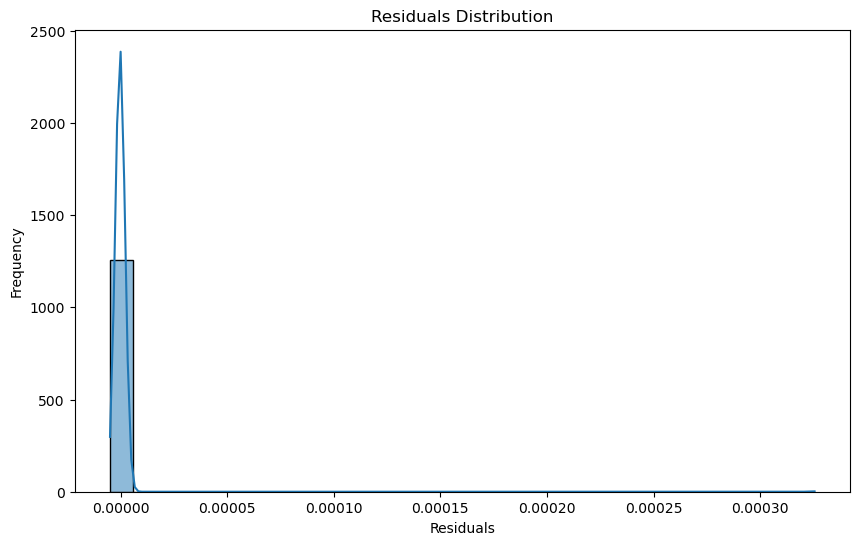

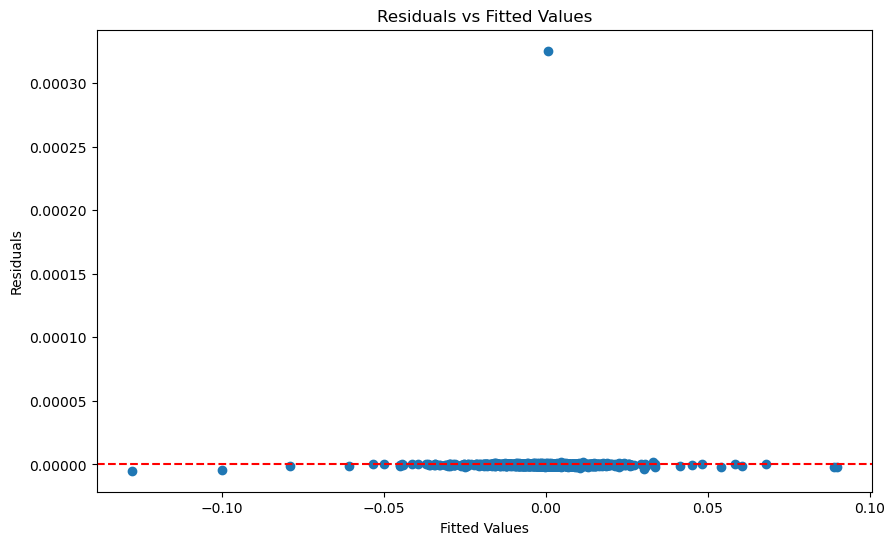

In [58]:
# Plot residuals
plt.figure(figsize=(10, 6))
sns.histplot(results.resid, bins=30, kde=True)
plt.title('Residuals Distribution')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Plot residuals vs fitted values to check homoscedasticity
plt.figure(figsize=(10, 6))
plt.scatter(results.fittedvalues, results.resid)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split data into train and test sets (e.g., 80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled_with_const, y, test_size=0.2, random_state=42)

# Fit the model on train set
model_train = sm.OLS(y_train, X_train)
results_train = model_train.fit()

# Predict on test set
y_pred = results_train.predict(X_test)

# Calculate RMSE on test set
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f'RMSE on Test Set: {rmse}')


RMSE on Test Set: 1.0091905967724578e-06
